In [1]:
import matplotlib.pyplot as plt
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Flatten
from keras import backend as K
import numpy as np 
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics 
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline           

Using TensorFlow backend.


In [2]:
help(applications)
# import sys
# !{sys.executable} -m pip install keras.applications

Help on package keras.applications in keras:

NAME
    keras.applications

PACKAGE CONTENTS
    densenet
    imagenet_utils
    inception_resnet_v2
    inception_v3
    mobilenet
    mobilenet_v2
    mobilenetv2
    nasnet
    resnet50
    vgg16
    vgg19
    xception

FUNCTIONS
    DenseNet121 = wrapper(*args, **kwargs)
    
    DenseNet169 = wrapper(*args, **kwargs)
    
    DenseNet201 = wrapper(*args, **kwargs)
    
    InceptionResNetV2 = wrapper(*args, **kwargs)
    
    InceptionV3 = wrapper(*args, **kwargs)
    
    MobileNet = wrapper(*args, **kwargs)
    
    MobileNetV2 = wrapper(*args, **kwargs)
    
    NASNetLarge = wrapper(*args, **kwargs)
    
    NASNetMobile = wrapper(*args, **kwargs)
    
    ResNet50 = wrapper(*args, **kwargs)
    
    VGG16 = wrapper(*args, **kwargs)
    
    VGG19 = wrapper(*args, **kwargs)
    
    Xception = wrapper(*args, **kwargs)
    
    keras_modules_injection(base_fun)

DATA
    absolute_import = _Feature((2, 5, 0, 'alpha', 1), (3, 0, 0, '

In [3]:
## create the base pre-trained model
# build the VGG16 network
base_model = applications.ResNet50(weights='imagenet', include_top=False, 
                                input_shape=(150,150,3))
print('Model loaded.')
base_model.summary()

W0215 16:32:21.521459 139777111516992 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0215 16:32:21.532786 139777111516992 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0215 16:32:21.536382 139777111516992 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0215 16:32:21.554043 139777111516992 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default

Model loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________________

In [4]:
# this is the model we will train
model =Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 36,642,305
Non-trainable params: 53,120
_________________________________________________________________


In [5]:
print('Number of trainable weights before freezing: ', len(model.trainable_weights))
## to freesze all convolutional layers in pretrained network method 1
# base_model.trainable=False

Number of trainable weights before freezing:  216


In [6]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred,0,1)))
#     possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall
# def precision_m(y_true, ypred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred,0,1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred,0,1)))
#     precision = true_positives/(predicted_positives+K.epsilon())
#     return precision 

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional pretrained layers method 2
for layer in base_model.layers:
    layer.trainable = False
print('After freezing: ', len(model.trainable_weights))
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'], loss='binary_crossentropy')


W0215 16:32:30.244230 139777111516992 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0215 16:32:30.250418 139777111516992 deprecation.py:323] From /home/mlab/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


After freezing:  4


In [7]:
train_data_dir = '/home/mlab/Documents/brats_hl_data/train'
validation_data_dir = '/home/mlab/Documents/brats_hl_data/val'
# 44938
# 5616
nb_train_samples = 44938
nb_validation_samples = 5616
epochs = 8
batch_size = 32
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

Found 44938 images belonging to 2 classes.
Found 5616 images belonging to 2 classes.


In [8]:
true_classes = train_generator.classes
print(true_classes)
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

[0 0 0 ... 1 1 1]
['high', 'low']


In [9]:
# train the model on the new data for a few epochs
history =model.fit_generator(train_generator,
                             steps_per_epoch=nb_train_samples//batch_size,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=nb_validation_samples//batch_size)

Epoch 1/8
351/351 [==============================] - 1117s 3s/step - loss: 0.5311 - acc: 0.7401 - val_loss: 0.3893 - val_acc: 0.8123
Epoch 2/8
351/351 [==============================] - 1082s 3s/step - loss: 0.3625 - acc: 0.8261 - val_loss: 0.3462 - val_acc: 0.8353
Epoch 3/8
351/351 [==============================] - 1085s 3s/step - loss: 0.3120 - acc: 0.8561 - val_loss: 0.3201 - val_acc: 0.8480
Epoch 4/8
351/351 [==============================] - 1086s 3s/step - loss: 0.2779 - acc: 0.8760 - val_loss: 0.2846 - val_acc: 0.8719
Epoch 5/8
351/351 [==============================] - 1087s 3s/step - loss: 0.2471 - acc: 0.8895 - val_loss: 0.2951 - val_acc: 0.8672
Epoch 6/8
351/351 [==============================] - 1095s 3s/step - loss: 0.2231 - acc: 0.9041 - val_loss: 0.2692 - val_acc: 0.8785
Epoch 7/8
351/351 [==============================] - 1114s 3s/step - loss: 0.2082 - acc: 0.9117 - val_loss: 0.3269 - val_acc: 0.8524
Epoch 8/8
351/351 [==============================] - 1121s 3s/step - 

In [10]:
true_classes_1 = validation_generator.classes
print(true_classes)
class_labels_1 = list(validation_generator.class_indices.keys())
print(class_labels_1)

[0 0 0 ... 1 1 1]
['high', 'low']


In [11]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)


In [12]:
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = (Y_pred<0.475).astype(np.int)

# print('Confusion Matrix')
# print(confusion_matrix(true_classes_1, y_pred))
# print('Classification Report')
# print(classification_report(validation_generator.classes, y_pred, 
#                             target_names=class_labels_1))


In [13]:
# print(validation_generator.classes)

In [14]:
confusion_matrix = metrics.confusion_matrix(true_classes_1,y_pred)
print(confusion_matrix)

[[1432 1343]
 [1473 1368]]


In [15]:
report= sklearn.metrics.classification_report(true_classes_1, y_pred, 
                                              target_names = class_labels_1)
print(report)

              precision    recall  f1-score   support

        high       0.49      0.52      0.50      2775
         low       0.50      0.48      0.49      2841

   micro avg       0.50      0.50      0.50      5616
   macro avg       0.50      0.50      0.50      5616
weighted avg       0.50      0.50      0.50      5616



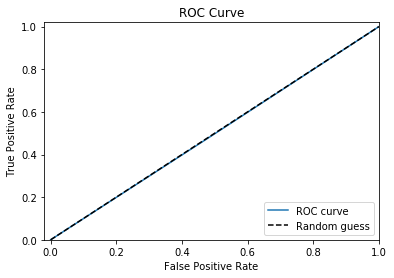

In [16]:
fpr, tpr, thresholds = roc_curve(validation_generator.classes, y_pred)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [17]:
roc_auc_score(validation_generator.classes, y_pred)

0.49877831368855663

In [18]:
batchX, batchy = train_generator.next()
_, accuracy = model.evaluate(batchX, batchy)
print('Accuracy training: %.2f' % (accuracy*100))
batchXv, batchyv = validation_generator.next()
_, accuracy = model.evaluate(batchXv, batchyv)
print('Accuracy val: %.2f' % (accuracy*100))

128/128 [==============================] - 3s 26ms/step
Accuracy training: 92.97
128/128 [==============================] - 3s 26ms/step
Accuracy val: 87.50


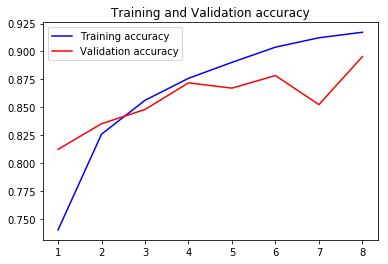

In [19]:
#plot the train and val curve
#get the details from the history object
acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

#train and validation accuracy
plt.plot(epochs,acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

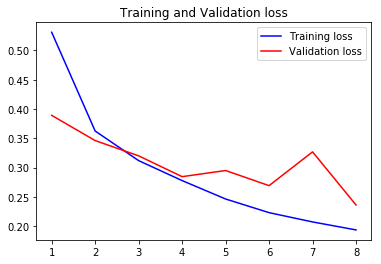

In [20]:
#train and validation loss
plt.plot(epochs, loss, 'b',label='Training loss')
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [21]:
test_generator = test_datagen.flow_from_directory('/home/mlab/Documents/brats_hl_data/test', 
                                      class_mode='binary', 
                                      batch_size=batch_size, 
                                      target_size=(150,150))
scores = model.evaluate_generator(test_generator, steps=nb_validation_samples//batch_size)

Found 5619 images belonging to 2 classes.


In [22]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 88.24%


In [23]:
#Confution Matrix and Classification Report
# Y_pred = model.predict_generator(val_generator, 5616 // batch_size)
nb_test_samples=5619
Y_pred1 = model.predict_generator(test_generator,nb_test_samples//batch_size+1)
# y_pred = np.argmax(Y_pred,axis=1)

In [24]:
true_classes_2 = test_generator.classes
print(true_classes_2)
class_labels_2 = list(test_generator.class_indices.keys())
print(class_labels_2)

[0 0 0 ... 1 1 1]
['high', 'low']


In [25]:
# y_pred1 = (Y_pred1<0.5).astype(np.int)
y_pred1 = (Y_pred1 < 0.475).astype(np.int)
# print(y_pred)
# print('Confusion Matrix')
# print(confusion_matrix(true_classes_2, y_pred1))
# print('Classification Report')
# print(classification_report(true_classes_2, y_pred1, target_names=class_labels_2))


In [26]:
confusion_matrix1 = metrics.confusion_matrix(true_classes_2,y_pred1)
print(confusion_matrix1)

[[1484 1292]
 [1495 1348]]


In [27]:
report1= sklearn.metrics.classification_report(true_classes_2, y_pred1, 
                                               target_names = class_labels_2)
print(report1)

              precision    recall  f1-score   support

        high       0.50      0.53      0.52      2776
         low       0.51      0.47      0.49      2843

   micro avg       0.50      0.50      0.50      5619
   macro avg       0.50      0.50      0.50      5619
weighted avg       0.50      0.50      0.50      5619



In [28]:
print(" Loss: ", scores[0],"\n","Accuracy: ", scores[1])

 Loss:  0.26137544769187304 
 Accuracy:  0.8824491279069767
